In [1]:
from __future__ import print_function

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import torch
import numpy as np
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

dtype = torch.float
device = torch.device("cpu")

In [6]:
from data_processing_hosvd import *
import slice_learning as sl
import hosvd as hosvd 
from tensorly.decomposition import tucker #tucker decomp package

In [7]:
data, p_list =prepare_data(since_1980=False, basin = 'EP')

number of storms in basin EP is 67
tensor shape is  [67, 15, 117]


In [8]:
data.shape

(67, 15, 117)

In [17]:
# Normalize 
x_min = data.min(axis=(2))
x_max = data.max(axis=(2))
data_n = data.copy()
for i in range(data.shape[2]):
    data_n[:,:,i]= (data[:,:,i] - x_min)/(x_max-x_min)

In [24]:
#analyse dimensional norms 
norms = round(hosvd.get_norms(data_n),2)
norms_pct = round(norms/norms.sum(axis=0),2)
norms = pd.concat([norms.add_prefix('dim '), norms_pct.add_suffix('_pct')], axis=1)
print(norms['0_pct'][:20].sum())
print(norms['1_pct'][:4].sum())
print(norms['2_pct'][:20].sum())
norms.head(20)

0.6900000000000001
0.74
0.8100000000000002


,dim 0,dim 1,dim 2,0_pct,1_pct,2_pct
0,158.83,158.81,151.16,0.24,0.41,0.26
1,62.05,84.81,79.46,0.09,0.22,0.14
2,38.52,23.66,44.71,0.06,0.06,0.08
3,25.93,18.32,30.62,0.04,0.05,0.05
4,20.81,15.44,23.73,0.03,0.04,0.04
5,16.88,13.73,17.90,0.03,0.04,0.03
6,15.24,12.09,15.07,0.02,0.03,0.03
7,13.59,11.61,13.43,0.02,0.03,0.02
8,12.25,9.95,10.99,0.02,0.03,0.02
9,11.58,9.63,10.37,0.02,0.02,0.02


In [37]:
def get_mse(T_true, T_hat):
    mse = np.power((T_hat-T_true),2).sum() 
    pct = np.power((T_hat-T_true),2).sum()/np.power(T_true,2).sum()*100
    print('mse, pct_mse =', np.round(mse,2), np.round(pct,2)) 
    return np.round(mse,2), np.round(pct,2)


#try different ranks 
rank_list=[[10,3,10],[15,3,15],[15,10,15],[20,10,15], [20,14,20],[40,14,40]] 
result = pd.DataFrame(columns={'ranks','pct_mse','mse'})
for ranks in rank_list:
    
    core, factors = tucker(data_n, ranks)
    print('rank of approximation tensor=', ranks)
    data_approx = hosvd.tucker_to_tensor(core, factors)
    mse, pct_mse = get_mse(data_n, data_approx)
    result= result.append({'ranks': ranks,
                  'mse': mse,
                  'pct_mse': pct_mse}, ignore_index=True)
    
result

rank of approximation tensor= [10, 3, 10]
mse, pct_mse = 2328.45 6.76
rank of approximation tensor= [15, 3, 15]
mse, pct_mse = 1987.17 5.77
rank of approximation tensor= [15, 10, 15]
mse, pct_mse = 1404.85 4.08
rank of approximation tensor= [20, 10, 15]
mse, pct_mse = 1131.84 3.29
rank of approximation tensor= [20, 14, 20]
mse, pct_mse = 995.64 2.89
rank of approximation tensor= [40, 14, 40]
mse, pct_mse = 301.15 0.87


,mse,pct_mse,ranks
0,2328.45,6.76,"[10, 3, 10]"
1,1987.17,5.77,"[15, 3, 15]"
2,1404.85,4.08,"[15, 10, 15]"
3,1131.84,3.29,"[20, 10, 15]"
4,995.64,2.89,"[20, 14, 20]"
5,301.15,0.87,"[40, 14, 40]"


USA_PRES


Text(0.5, 1.0, 'Feature: STORM_SPEED')

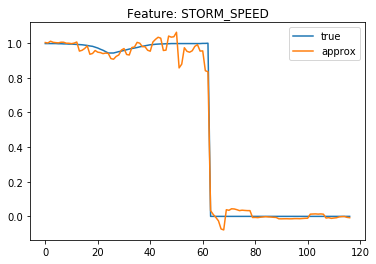

In [38]:
storm_id = 29
p = 4
print(p_list[p])
plt.plot(data_n[storm_id, p, :], label='true')
plt.plot(data_approx[storm_id, p, :], label='approx')
plt.legend()
plt.title('Feature: STORM_SPEED')

In [ ]:
# #now let's try with Colin's code 
# aprx2= sl.slice_learning(data_np, r=5)


In [ ]:
#now let's try if we can learn the last slice! 
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl #tensorly package
from tensorly.decomposition import tucker #tucker decomp package


class tucker_forward(torch.nn.Module):
    # m,n,t is the size of input x, k is the low rank
    def __init__(self, x, ranks, I, hosvd_init=True):

        super(tucker_forward, self).__init__()

        if hosvd_init==True:
            # mask out last slice 
            x_mask = torch.mul(x,I)
            #do hosvd 
            s, factors = tucker(x.numpy(), ranks)

            # register parameters
            self.S = torch.nn.Parameter(torch.tensor(np.array(s), requires_grad=True))
            self.U0= torch.nn.Parameter(torch.tensor(np.array(factors[0]), requires_grad=True))
            self.U1= torch.nn.Parameter(torch.tensor(np.array(factors[1]), requires_grad=True))
            self.U2= torch.nn.Parameter(torch.tensor(np.array(factors[2]), requires_grad=True))

        else:
            self.S = torch.nn.Parameter(torch.rand(ranks))
            self.U0= torch.nn.Parameter(torch.randn(x.shape[0],ranks[0]))
            self.U1= torch.nn.Parameter(torch.randn(x.shape[1],ranks[1]))
            self.U2= torch.nn.Parameter(torch.randn(x.shape[2],ranks[2]))


    def forward(self, x):
        t1=torch.einsum('ijk,li->ljk', self.S, self.U0) #mode 1 product: i to l
        t2=torch.einsum('ijk,lj->ilk', t1, self.U1) #mode 2 product: j to l
        x_hat=torch.einsum('ijk,lk->ijl', t2, self.U2)#mode 3 product k to l
        return x_hat


def loss_fn(x_hat, x, I):
    lamda = 10 
    loss =  (x_hat - x).pow(2).sum() + lamda* torch.matmul((x_hat - x), (1-I)).pow(2).sum()
    return loss


#define function
def run_tucker(x, ranks, I,max_itr=500, lr=1e-6, hosvd_init=True, plot_loss=False): #x: input torch.Tensor

    m,n,t = x.shape
    model = tucker_forward(x, ranks, I, hosvd_init)

    loss_arr =[] #record loss trajectory
    ugrad_arr=[]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for t in range(max_itr):
        optimizer.zero_grad()
        x_hat= model(x)
        loss = loss_fn(x_hat, x, I)
        loss.backward()
        optimizer.step()

        #record loss and gradients
        loss_arr.append(loss.detach().item())


    x_hat = model(x)
    final_itr = t

    if plot_loss:
        plt.plot(loss_arr)

    return loss_arr, x_hat



In [41]:
I = np.eye(3)
1-I


array([[0., 1., 1.],
       [1., 0., 1.],
       [1., 1., 0.]])

In [ ]:
# ---- old code ----- 

In [10]:
# #Methods to standardize and de_standardize data along samples and timesteps (full standardization)
# def standardize2(tensor): 
#     new_tensor = tensor.clone()
#     #calculate along 0 and 2nd (python index) dimension 
#     std, mean = torch.std(tensor, dim=[0,2]), torch.mean(tensor, dim=[0,2])
#     t = tensor.shape[1]
#     for i in range(t):
#         #element wise division
#         new_tensor[:,i,:] = torch.div((tensor[:,i,:] - mean[i]), std[i])  
#     #replace Nan with 0 
#     new_tensor[new_tensor != new_tensor] = 0
#     return new_tensor, mean, std

# def de_standardize2(tensor, mean, std):
#     t = tensor.shape[1]
#     new_tensor = tensor.clone()
#     for i in range(t):
#         #element wise multiplication
#         new_tensor[:,i,:] = torch.mul(tensor[:,i,:], std[i]) + mean[i] 
#     return new_tensor 

In [11]:
# #plot error bar chart
# def plot_error(data, X_imputed, storm_id, p_list):#calculate error for all features for next 5 hour prediction: 
#     error_5=[]
#     error_10=[]
#     error_15=[]
#     for p in range(len(p_list)):
#         #for each time
#         error_v=np.abs((X_imputed[storm_id][p] - data[storm_id][p])/data[storm_id][p]) #percentage error 
#         error_5.append((error_v[time+5-1:time+5+1].sum()*(1/3)))#avg of time +5
#         error_10.append((error_v[time+10-1:time+10+1].sum()*(1/3)))#avg of time +10
#         error_15.append((error_v[time+15-1:time+15+1].sum()*(1/3)))#avg of time +15
    
#     #plotting error:
#     ind = np.arange(len(p_list)) 
#     width = 0.3 
#     plt.bar(ind,error_5,width, label='t+5')
#     plt.bar(ind+width,error_10,width, label='t+10')
#     plt.bar(ind+2*width,error_15,width, label='t+15')
#     plt.xticks(ind + width / 2, p_list)
#     plt.title('Avg pct error for t+5/10/15 StormID=%s' %(storm_id))
#     plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
#     plt.legend(loc='best')
#     plt.show()
#     return 

# def plot_feature_prediction(data, X_imputed_0, X_imputed_1, X_imputed_2, storm_id, p_list, p_range, no_scale = False):
#     for p in p_range:
#         #plot predicted feature p with various normalization methods: 
#         l = [i for i in range(data.shape[2])]
#         if no_scale:
#             plt.plot(l, np.array(X_imputed_0[storm_id][p]), label='imputed_no_scale')
#         plt.plot(l, np.array(X_imputed_1[storm_id][p]),label='imputed_normalize')
#         plt.plot(l, np.array(X_imputed_2[storm_id][p]), label='imputed_standardize')
#         plt.plot(l, np.array(data[storm_id][p]),label='real')
#         plt.axvline(x=time)
#         plt.legend()
#         plt.title('Feature= %s, StormID=%s' %(p_list[p],storm_id))
#         plt.show()
#     return 

In [12]:
# def get_data_test(true_data, storm_id, time):
#     test_data = true_data.clone()
#     for t in range(time,true_data.shape[2]):
#         test_data[storm_id,:,t] = test_data[storm_id,:,time-1]
#     return test_data

In [13]:
# #Testing function by deleting entries after time t for one particular storm  
# def test(data, p_list, storm_id, time, r, p = 2, delete = True):
#     data0 = data.clone()
    
#     #data0= delete one storm data for testing  
#     if delete:    
#         data0 = get_data_test(data, storm_id, time)
    
#     ### slice_learning 0: no_scale 
#     X_imputed_0 = slice_learning(data0,r)
    
#     ### slice learning 1: normalize data 
#     data1 = F.normalize(data0, dim = 2)
#     X_imputed_1 = slice_learning(data1,r)
#     #de_normalize
#     scale = torch.div(data[:,:,:time],X_imputed_1[:,:,:time])
#     scale_mean = torch.mean(scale, dim=2)
#     for i in range(X_imputed_1.shape[2]):
#         X_imputed_1[:,:,i] = torch.mul(X_imputed_1[:,:,i], scale_mean) 
    
#     ### slice_learning 2: standardize
#     data2, mean, std = standardize2(data0)
#     X_imputed_2 = slice_learning(data2, r)
#     #de_standardize 
#     X_imputed_2= de_standardize2(X_imputed_2, mean, std)
    
#     return X_imputed_0, X_imputed_1, X_imputed_2

r = 8
Code stopped at iteration = 50, and mae difference = 166830.75
Code stopped at iteration = 50, and mae difference = 0.002504379255697131
Code stopped at iteration = 50, and mae difference = 0.0200358759611845


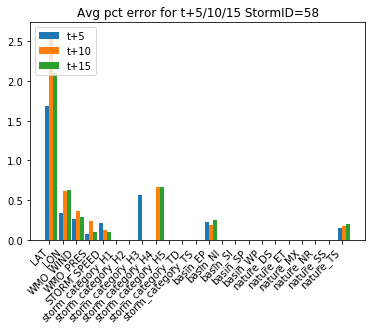

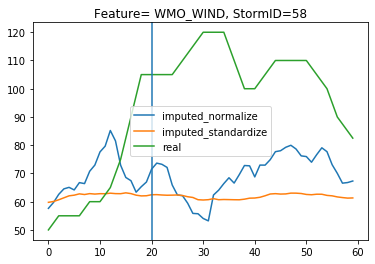

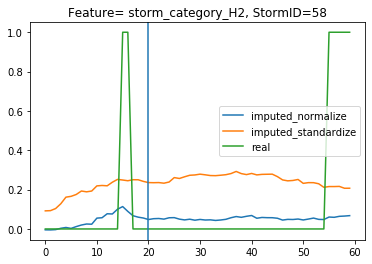

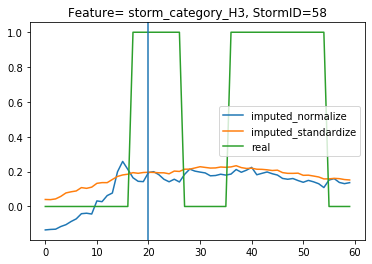

r = 13
Code stopped at iteration = 50, and mae difference = 37.09054946899414
Code stopped at iteration = 50, and mae difference = 0.005414701998233795
Code stopped at iteration = 50, and mae difference = 0.051613759249448776


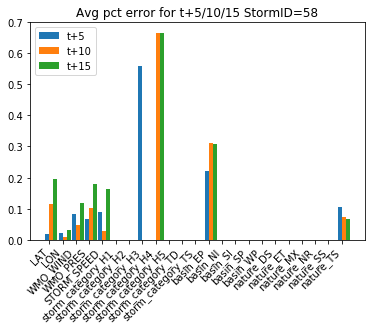

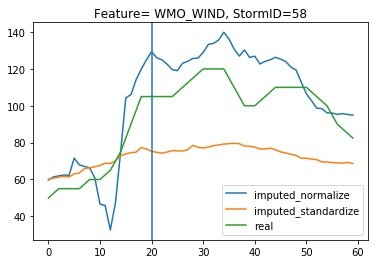

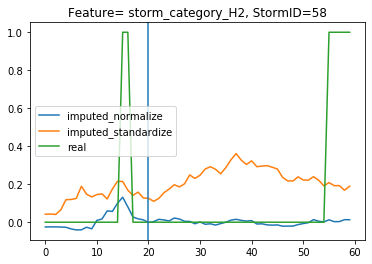

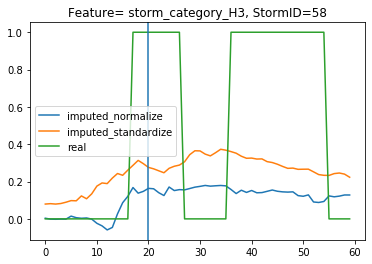

r = 20
Code stopped at iteration = 50, and mae difference = 42.03227233886719
Code stopped at iteration = 50, and mae difference = 0.005354554858058691
Code stopped at iteration = 50, and mae difference = 0.08878912776708603


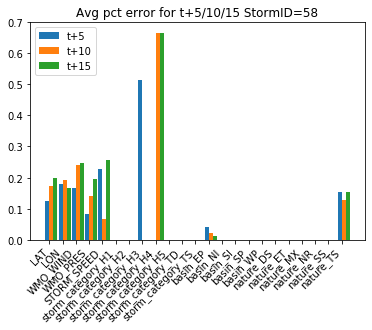

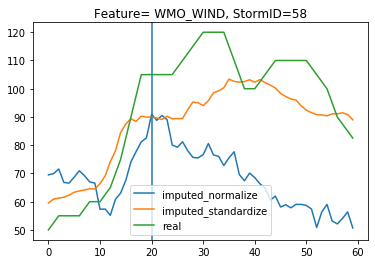

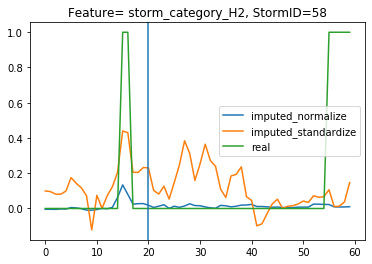

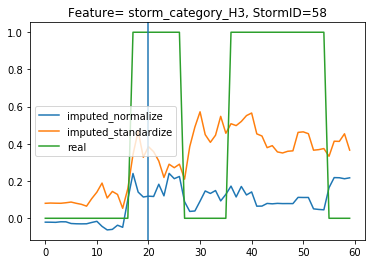

In [14]:
# #60 is big storm not easy to predict
# storm_id = 58
# time = 20
# data = data_2016_nodist
# p_list = p_list_2016_nodist
# for r in [8,13, 20]:
#     print ('r =', r)
#     #test learning for a particular storm_id 
#     X_imputed_0, X_imputed_1, X_imputed_2 = test(data, p_list, storm_id, time, r, delete = True)
#     #make some plots:
#     plot_error(data, X_imputed_1, storm_id, p_list)
#     plot_feature_prediction(data, X_imputed_0, X_imputed_1, X_imputed_2, storm_id, p_list, p_range=[2, 6, 7])

Code stopped at iteration = 50, and mae difference = 54.31429672241211
Code stopped at iteration = 50, and mae difference = 33.93944549560547
Code stopped at iteration = 50, and mae difference = 37.03579330444336
Code stopped at iteration = 50, and mae difference = 35.57888412475586
Code stopped at iteration = 50, and mae difference = 46.03409957885742


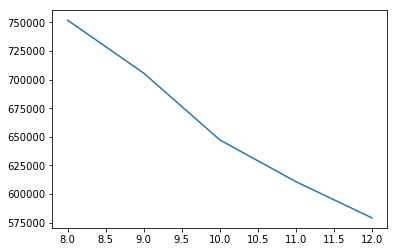

[751936.5, 705677.375, 647327.5625, 610805.5625, 579140.875]

In [99]:
# #get best r

# def get_best_r(data, r_min, r_max):
#     r_list = []
#     for r in range(r_min, r_max):
#         X_imputed = slice_learning(data,r, plot = False)
#         r_list.append(get_mae(X_imputed,data))
#     plt.plot([r for r in range(r_min, r_max)], r_list)
#     plt.show()
#     return r_list

# get_best_r(data_1980_nodist, 8, 13)